In [52]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os 
from warnings import simplefilter
import pandas as pd
import ast

In [53]:
df = pd.read_csv('results/auc_analysis.csv')
df2 = pd.read_csv('results/auc_analysis_other_methods.csv')

In [54]:
df.iloc[0].ratio

'(1, 1)'

In [55]:
df2.head(100)

,name,num_classes,classes_used,ratio,learning_rate,mean_0,variance_0,mean_10,variance_10,mean_20,variance_20,mean_30,variance_30,mean_40,variance_40,mean_50,variance_50
0,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-05,0.548379,0.009424,0.795643,0.000310,0.811737,0.000240,0.824414,0.000099,0.832690,0.000065,0.833195,0.000075
1,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-06,0.534905,0.008606,0.681391,0.000837,0.710880,0.000407,0.727316,0.000248,0.739475,0.000126,0.748051,0.000146
2,focal_loss,2,"(0, 1)","(10, 1)",5.000000e-07,0.527536,0.008331,0.626403,0.002741,0.652678,0.001678,0.675109,0.000896,0.692836,0.000571,0.706391,0.000421
3,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-07,0.511716,0.005766,0.629553,0.000905,0.633981,0.001234,0.642189,0.001189,0.649791,0.001168,0.657057,0.001119
4,focal_loss,2,"(0, 1)","(10, 1)",1.000000e-08,0.514619,0.003869,0.606348,0.005053,0.618047,0.004917,0.621067,0.004912,0.621507,0.005161,0.622151,0.005368
5,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-05,0.548379,0.009424,0.685143,0.001857,0.699112,0.001336,0.710292,0.001627,0.723222,0.001115,0.730072,0.000760
6,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-06,0.534905,0.008606,0.665107,0.001244,0.670212,0.001120,0.674868,0.001048,0.678642,0.000992,0.681752,0.000921
7,focal_loss,2,"(0, 1)","(100, 1)",5.000000e-07,0.527536,0.008331,0.623713,0.002348,0.626058,0.002377,0.629031,0.002310,0.631543,0.002338,0.634038,0.002342
8,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-07,0.511716,0.005766,0.640864,0.001435,0.646886,0.001271,0.649821,0.001016,0.651862,0.000942,0.654895,0.000731
9,focal_loss,2,"(0, 1)","(100, 1)",1.000000e-08,0.514619,0.003869,0.607222,0.005031,0.619494,0.004726,0.624681,0.004557,0.627084,0.004383,0.628821,0.004219


In [56]:
df.ratio = df.ratio.apply(lambda x : ast.literal_eval(x))
df.classes_used = df.classes_used.apply(lambda x : ast.literal_eval(x))
df2.ratio = df2.ratio.apply(lambda x : ast.literal_eval(x))
df2.classes_used = df2.classes_used.apply(lambda x : ast.literal_eval(x))

In [59]:
# To-do: 
# loss + gradient descent 
# effective # of samples - implement + read again
# retrain w/ new learning rates 
# 2 class normal - 1e-05 - 1e-06
# 3 class results - for each class
# image augmentations? 
# try smote with MNIST 
# smote from Github 
# add focal loss and SMOTE to graphs 
# CNNs? 

# capping loss for SMOTE 

# choosing examples for SMOTE 

# focal loss + SMOTE (+ parameter updates) (less weight to synthetic examples)
    # utilize a new label - is it synthetically generated or original image 
    # how much to utilize this 
        # synthetic label correctness? 
    # changes to loss function or gradient descent to optimize learning 
    # neural network architecture? w/ embeddings and final output 
        # SMOTE on embeddings 
    # gradient updates - review current methods (Momentum, Adam) 
# loss + tune and train set accuracy every epoch to see if parameter helped 
    # what direction are examples causing weights to move 

# Done:
# 10 : 1 
# focal loss - read + implement (need to check if it works)
# try new plots - best lr? 
# smote - implement (still need to check)


# Roadmap:

# run 3 class focal loss + graph if time 

# smote w/ MNIST 

# CNNs on CIFAR10 (and MNIST?) 
    # try all methods so far 
    # compare data 
    # finish 3 class 

# capping loss for SMOTE on logistic regression 
    # and CNNs 

# embeddings 
    # SMOTE
    # combined loss function w embeddings (unsupervised learning) and final output (supervised) 

# lookahead feature 
    # with smote (or anything) - weight updates 
    # downweight examples 


    
ratio = (10, 1)

NUM_CLASSES= 2

normal_df = df.loc[(df.name=='normal') & (df.num_classes==NUM_CLASSES)]
ratio_df = df.loc[(df.name=='ratio') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
oversampled_df = df.loc[(df.name=='oversampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
weighted_df = df.loc[(df.name=='weighted') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
undersampled_df = df.loc[(df.name=='undersampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]
bothsampled_df = df.loc[(df.name=='both_sampled') & (df.num_classes==NUM_CLASSES) & (df.ratio==ratio)]

smote_df = df2.loc[(df2.name=='smote') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]
focalloss_df = df2.loc[(df2.name=='focal_loss') & (df2.num_classes==NUM_CLASSES) & (df2.ratio==ratio)]

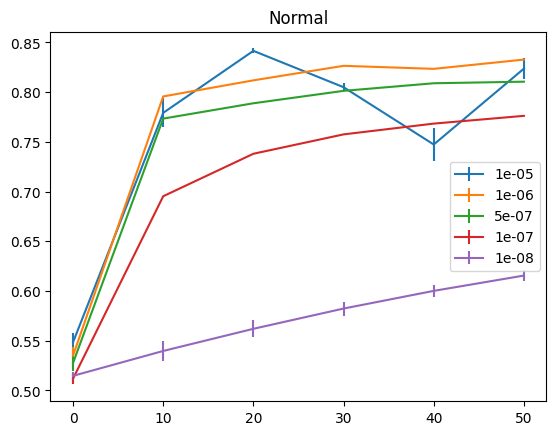

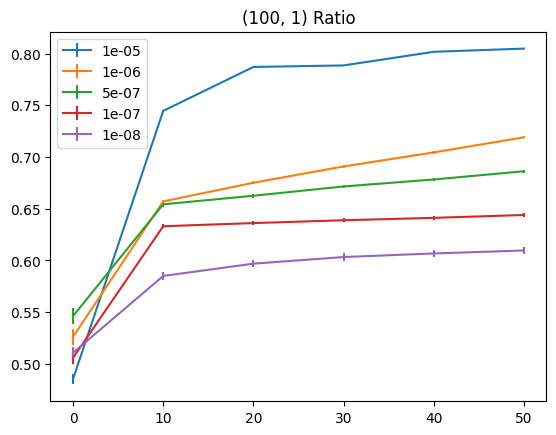

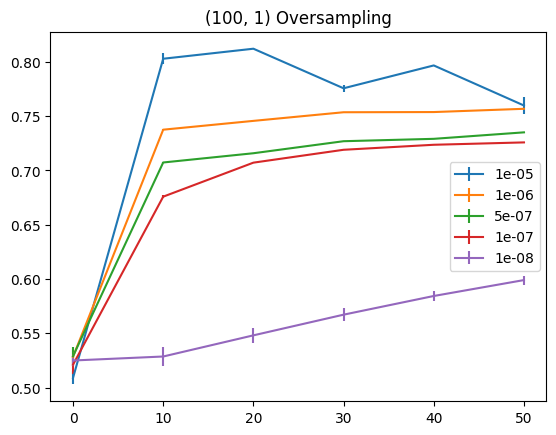

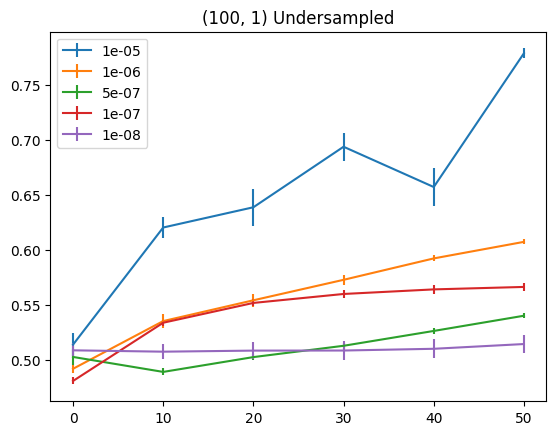

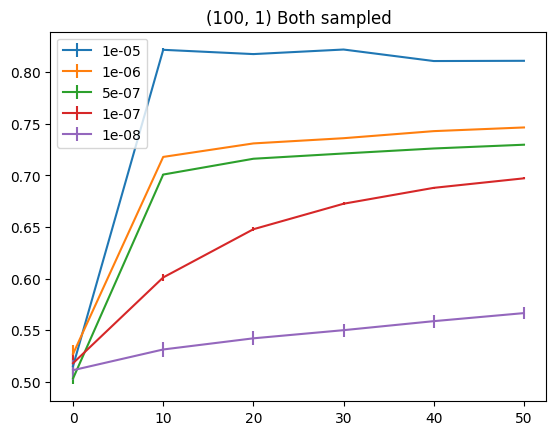

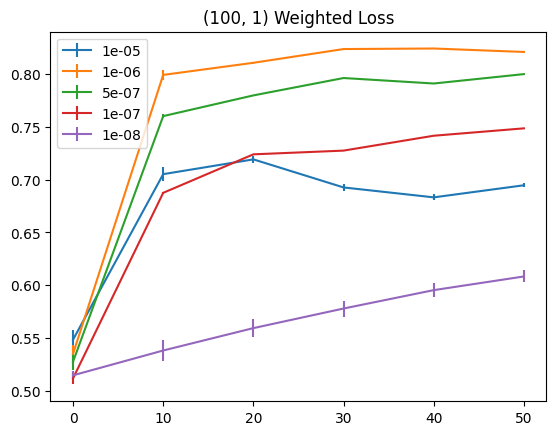

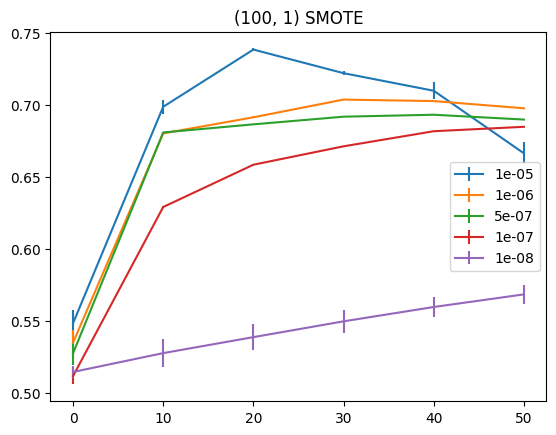

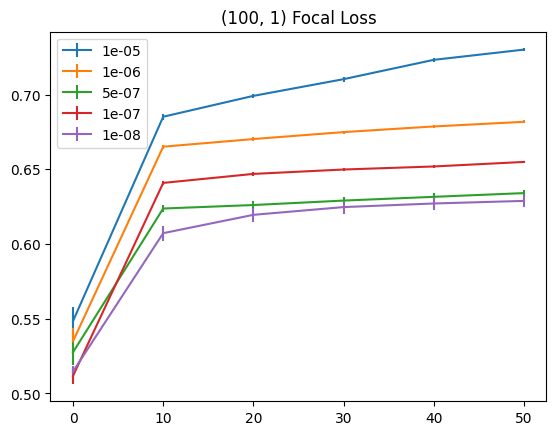

In [60]:
best_lrs={}

epochs = [0, 10, 20, 30, 40, 50]
mean_cols = ["mean_" + str(epoch )for epoch in epochs]
variance_cols = ["variance_" + str(epoch )for epoch in epochs]


best_mean=0
for index, row in normal_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title("Normal")
plt.legend()
plt.show()

best_mean=0
for index, row in ratio_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Ratio")
plt.legend()
plt.show()

best_mean=0
for index, row in oversampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Oversampling")
plt.legend()
plt.show()

best_mean=0
for index, row in undersampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Undersampled")
plt.legend()
plt.show()


best_mean=0
for index, row in bothsampled_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Both sampled")
plt.legend()
plt.show()

best_mean=0
for index, row in weighted_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
plt.title(str(row['ratio']) + " Weighted Loss")
plt.legend()
plt.show()

for index, row in smote_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
    plt.title(str(row['ratio']) + " SMOTE")
plt.legend()
plt.show()


for index, row in focalloss_df.iterrows(): 
    means = [row[mean_name] for mean_name in mean_cols]
    variances = [row[variance] for variance in variance_cols]
    plt.errorbar(epochs, means, yerr=variances, label=row['learning_rate'])
    if row['mean_50'] >= best_mean: 
        best_lrs[row['name']]=row['learning_rate']
        best_mean=row['mean_50']
    plt.title(str(row['ratio']) + " Focal Loss")
plt.legend()
plt.show()

In [88]:
print(best_lrs)

{'normal': 1e-06, 'ratio': 1e-05, 'oversampled': 1e-05, 'undersampled': 1e-05, 'both_sampled': 1e-06, 'weighted': 1e-06}


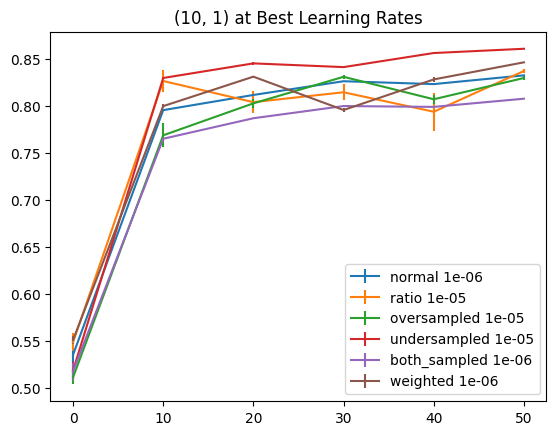

In [89]:
for key in best_lrs:
    means = []
    variances = []
    for epoch in epochs: 
        mean = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['mean_' + str(epoch)].iloc[0]

        var = df.loc[(df.name==key) & (df.num_classes==NUM_CLASSES) & (df.learning_rate==best_lrs[key]) & ((df.ratio==ratio) | (df.ratio==(1, 1)))]['variance_' + str(epoch)].iloc[0]
        means.append(mean)
        variances.append(var)
    plt.errorbar(epochs, means, yerr=variances, label=key + " " + str(best_lrs[key]))
plt.title(str(row['ratio']) + " at Best Learning Rates")
plt.legend()
plt.show()
